# Machine Learning: The DL on ML

This replicates, in a jupyter notebook, the code found in Chapter 7 ("Machine Learning: The DL<sup>1</sup> on ML") of Meredith Broussard's _Artificial Unintelligence: How Computers Misunderstand the World_ (MIT Press, 2015, https://mitpress.mit.edu/books/artificial-unintelligence). As Broussard notes, her treatment is a simplified version of the Kaggle Python Tutorial on Machine Learning at Datacamp (https://www.datacamp.com/community/open-courses/kaggle-python-tutorial-on-machine-learning), but I think it is also helpful to have a companion following the book chapter. 

I think Broussard's chapter is the single best overview of machine learning for a non-technical audience in terms of (hopefully) demystifying machine learning, and providing an alternative narrative to those of commonly made public claims. The commentary she provides while going through the example emphasizes 
- the _tedium_ of doing machine learning, 
- the surprising simplicity (and even "stupidity") of much of it, and 
- some fundamental limitations in data and modeling (such as through her point about numbering of rafts; this can be phrased as a problem of a latent variable being causal, but so can many cases of features that predict well in data from one case but will fail to generalize). 

This notebook is to help anybody who might want to move from that treatment to a technical one, or perhaps see the visual artifact of what doing machine learning/data science would look like, in context (on an analyst's computer, rather than filtered through the book's typography). To actually run this notebook, you will unfortunately need to go through a standard but still laborious process of installing multiple things on your computer. 

I would like to point out two technical mistakes in the chapter:
1. Feature importance is NOT the same as statistical significance! They frequently coincide, but it is possible to have an important feature that is not statistically significant, and conversely, it is possible to have a statistically significance variable low in feature importance. Feature importance has to do with the (normalized) size of an effect, whereas statistical significance has to do with the amount of variance of that effect across observations, given the sample size. This difference is further explored in the literature around "post-selection inference."
2. The test accuracy is .72, NOT .97! After following the tutorial and getting the same training  accuracy of .97 (such that I imagine I got the same decision tree, since various implementations of decision trees in R only gave around .83-.87 accuracy). But submitting the predicted values to Kaggle, the accuracy I got was .71770. The fact that test performance is always worse than training performance is important, as it illustrates overfitting. And, there are ways that the performance on truly new data might again be worse than even the test performance (if there was sampling bias towards observations with a strong signal; if there are temporal, spatial, network, or other dependencies in the data that the data splitting does not or cannot control for; and if we set aside data to serve only as a test set but try to many models that we end up overfitting over a distribution over models). 

Additionally, there is one typographic error: all of the python code has commas inside quotes, perhaps the result of a careless "find+replace all" of <",> with <,">. Be aware of this if you copy code from the book, but it's fixed in the copy below. 

In the book chapter, there are some redundant commands (in the text, each instance has a different explanation); I kept these for faithfulness to the chapter. These commands follow train.describe(). 

> <sup>1</sup> "DL" here stands for "down-low" and here means something like "secrets". Now mainstream, I believe it comes from appropriating queer black slang. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, preprocessing

In [2]:
train_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv"
train = pd.read_csv(train_url)
test_url = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv"
test = pd.read_csv(test_url)

In [3]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [7]:
train["Survived"].value_counts() # Note: redundant with two lines down

0    549
1    342
Name: Survived, dtype: int64

In [8]:
print(train["Survived"].value_counts(normalize = True)) # Note: redundant with two lines down

0    0.616162
1    0.383838
Name: Survived, dtype: float64


In [9]:
# Passengers that survived vs passengers that passed away
print(train["Survived"].value_counts())

0    549
1    342
Name: Survived, dtype: int64


In [10]:
# As proportions
print(train["Survived"].value_counts(normalize = True))

0    0.616162
1    0.383838
Name: Survived, dtype: float64


In [11]:
# Males that survived vs males that passed away
print(train["Survived"][train["Sex"] == 'male'].value_counts())

0    468
1    109
Name: Survived, dtype: int64


In [12]:
# Females that survived vs females that passed away
print(train["Survived"][train["Sex"] == 'female'].value_counts())

1    233
0     81
Name: Survived, dtype: int64


In [13]:
# Normalized male survival
print(train["Survived"][train["Sex"] == 'male'].value_counts(normalize=True))

0    0.811092
1    0.188908
Name: Survived, dtype: float64


In [14]:
# Normalized female survival
print(train["Survived"][train["Sex"] == 'female'].value_counts(normalize=True))

1    0.742038
0    0.257962
Name: Survived, dtype: float64


In [15]:
train["Age"] = train["Age"].fillna(train["Age"].median())

In [16]:
# Print the train data to see the available features
print(train)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

In [17]:
# Create the target and features numpy arrays: target, features_one
target = train["Survived"].values

In [18]:
# Preprocess
encoded_sex = preprocessing.LabelEncoder()

In [19]:
# Convert into numbers
train.Sex = encoded_sex.fit_transform(train.Sex)
features_one = train[["Pclass", "Sex", "Age", "Fare"]].values

In [20]:
# Fit the first decision tree: my_tree_one
my_tree_one = tree.DecisionTreeClassifier()
my_tree_one = my_tree_one.fit(features_one, target)

In [21]:
# Look at the importance and score of the included features
print(my_tree_one.feature_importances_)

[ 0.12717495  0.31274009  0.23499587  0.32508908]


In [22]:
print(my_tree_one.score(features_one, target))

0.977553310887


In [23]:
# Fill any missing fare values with the median fare
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

In [24]:
# Fill any missing age values with the median age
test["Age"] = test["Age"].fillna(test["Age"].median())

In [25]:
# Preprocess
test_encoded_sex = preprocessing.LabelEncoder()
test.Sex = test_encoded_sex.fit_transform(test.Sex)

In [26]:
# Extract important features from the test set: Pclass, Sex, Age, and Fare
test_features = test[["Pclass", "Sex", "Age", "Fare"]].values
print('These are the features:\n')
print(test_features)

These are the features:

[[  3.       1.      34.5      7.8292]
 [  3.       0.      47.       7.    ]
 [  2.       1.      62.       9.6875]
 ..., 
 [  3.       1.      38.5      7.25  ]
 [  3.       1.      27.       8.05  ]
 [  3.       1.      27.      22.3583]]


In [27]:
# Make a prediction using the test set and print
my_prediction = my_tree_one.predict(test_features)
print('This is the prediction:\n')
print(my_prediction)

This is the prediction:

[0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [28]:
# Create a data frame with two columns: PassengerId & Survived 
# Survived contains the model’s prediction
PassengerId =np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])
print('This is the solution in toto:\n')
print(my_solution)

This is the solution in toto:

      Survived
892          0
893          0
894          1
895          1
896          1
897          0
898          0
899          0
900          1
901          0
902          0
903          0
904          1
905          1
906          1
907          1
908          0
909          1
910          1
911          0
912          0
913          1
914          1
915          0
916          1
917          0
918          1
919          1
920          1
921          0
...        ...
1280         0
1281         0
1282         0
1283         1
1284         0
1285         0
1286         0
1287         1
1288         0
1289         1
1290         0
1291         0
1292         1
1293         0
1294         1
1295         1
1296         0
1297         0
1298         0
1299         0
1300         1
1301         1
1302         1
1303         1
1304         0
1305         0
1306         1
1307         0
1308         0
1309         0

[418 rows x 1 columns]


In [29]:
# Check that the data frame has 418 entries
print('This is the solution shape:\n')
print(my_solution.shape)

This is the solution shape:

(418, 1)


In [30]:
# Write the solution to a CSV file with the name my_solution.csv
my_solution.to_csv("my_solution_one.csv", index_label = ["PassengerId"])

Now, you can submit this csv at https://www.kaggle.com/c/titanic/leaderboard. This requires registering with Kaggle. If you do submit, you should get an accuracy of 0.72248. 

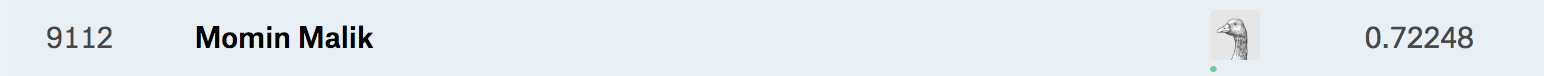

To push this further, by visualizing the tree we can see it is extremely complex for only a few variables and observations, which is a clue that it is overfitted. In order to plot the tree, you will need to install graphviz, e.g., `conda install python-graphviz` in the command line.

In [31]:
from graphviz import Source
Source(tree.export_graphviz(my_tree_one, out_file='None', feature_names=["Pclass", "Sex", "Age", "Fare"]))

I exported this as a file in order to convert to an embeddable image with `tree.export_graphviz(my_tree_one, out_file='tree.dot', feature_names=["Pclass", "Sex", "Age", "Fare"])`.

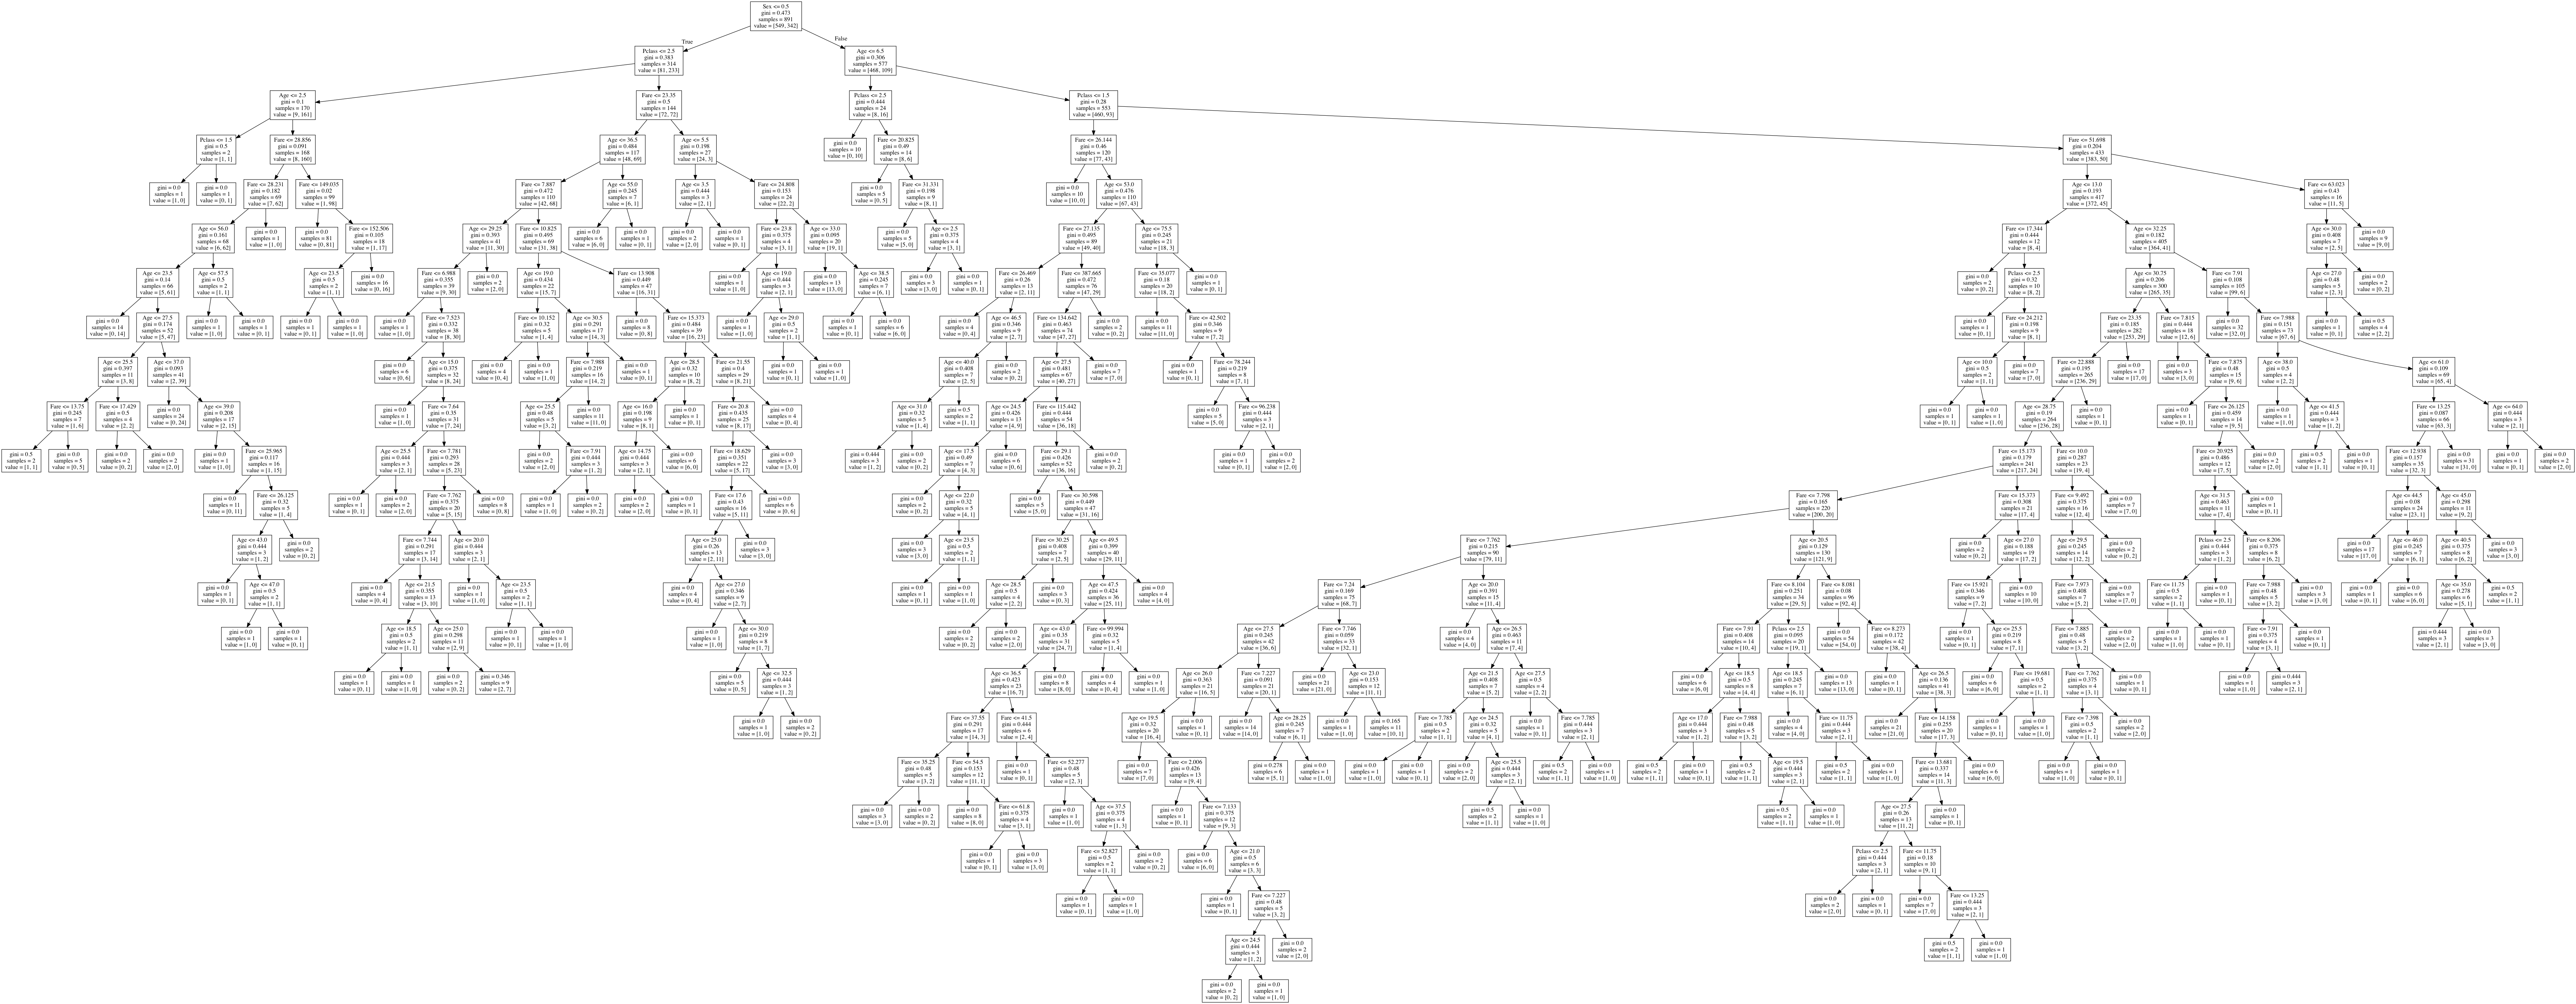

To zoom in, look at the pdf at [https://github.com/momin-malik/guides/blob/master/tree.pdf](https://github.com/momin-malik/guides/blob/master/tree.pdf).